In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [66]:
# Load the data
file_path = 'nohHG002_CCS.comb.chr2.bed'  
data = pd.read_table(file_path, header=None, names=['s','e','coverage','copynumber','mean','p/f'])
data.head()


,s,e,coverage,copynumber,mean,p/f
0,0,100,0,0,0,PASS
1,100,200,0,0,0,PASS
2,200,300,0,0,0,PASS
3,300,400,0,0,0,PASS
4,400,500,0,0,0,PASS


In [67]:
data.describe()

,s,e,coverage,copynumber,mean
count,5.046600e+05,5.046600e+05,504660.000000,504660.000000,504660.000000
mean,1.200470e+08,1.200471e+08,40.792758,2.461007,39.871002
std,6.691796e+07,6.691796e+07,31.496431,1.058824,17.058673
min,0.000000e+00,1.000000e+02,0.000000,0.000000,0.000000
25%,6.693548e+07,6.693558e+07,42.000000,3.000000,44.000000
50%,1.128664e+08,1.128666e+08,46.000000,3.000000,46.000000
75%,1.788414e+08,1.788415e+08,49.000000,3.000000,48.000000
max,2.421934e+08,2.421935e+08,1731.000000,6.000000,181.000000


In [68]:
nonzero_cov = data[data['coverage'] > 0]
nonzero_cov.describe()

# remove 0 values as they provide no insight, an empty site is an empty site

,s,e,coverage,copynumber,mean
count,4.667970e+05,4.667970e+05,466797.000000,466797.000000,466797.000000
mean,1.220957e+08,1.220958e+08,44.101554,2.660606,43.104244
std,6.909659e+07,6.909659e+07,30.439570,0.825223,13.236058
min,1.010000e+04,1.020000e+04,1.000000,0.000000,0.000000
25%,6.277270e+07,6.277280e+07,44.000000,3.000000,45.000000
50%,1.232038e+08,1.232039e+08,46.000000,3.000000,46.000000
75%,1.822149e+08,1.822150e+08,49.000000,3.000000,48.000000
max,2.421833e+08,2.421834e+08,1731.000000,6.000000,181.000000


In [77]:
# Calculate summary statistics
coverage_mean = nonzero_cov['coverage'].mean()
coverage_var = nonzero_cov['coverage'].var()
coverage_max = nonzero_cov['coverage'].max()

# Scale coverage by the haploid mean 
haploid_mean_coverage = nonzero_cov['coverage'].mean() /2


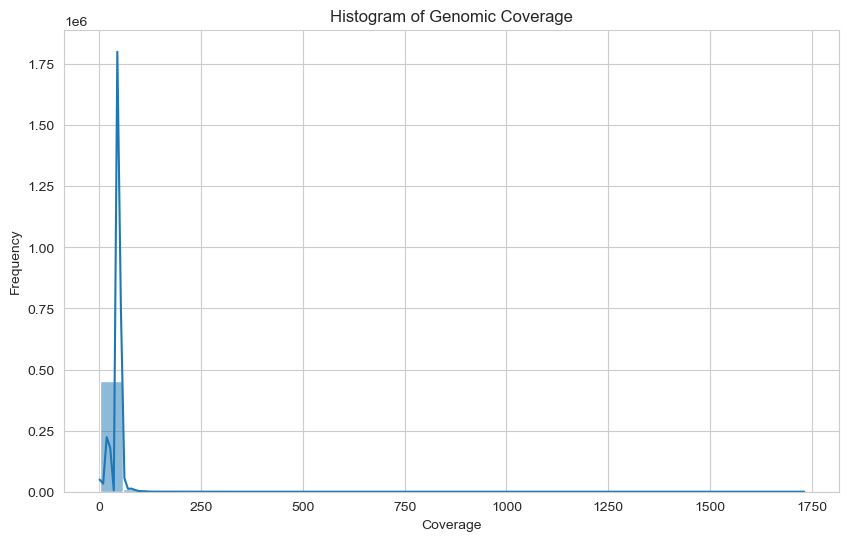

In [70]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")


# Plot the histogram with a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(nonzero_cov['coverage'], kde=True, bins=30)
plt.title('Histogram of Genomic Coverage')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.show()

## this shows overdispersion


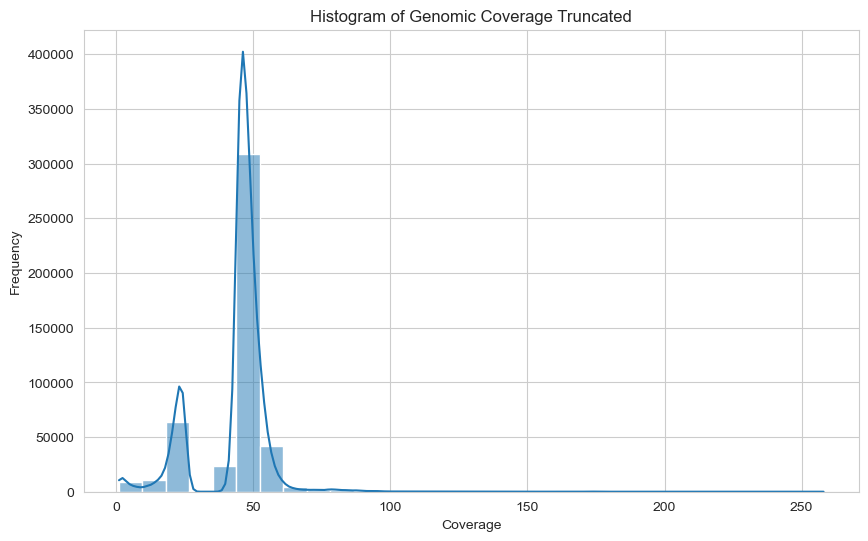

In [73]:
sns.set_style("whitegrid")

#set max cov to 12 * Hmean
MAX_cov = haploid_mean_coverage * 12

plt.figure(figsize=(10, 6))
sns.histplot(nonzero_cov.loc[nonzero_cov['coverage'] < MAX_cov, 'coverage'], kde=True, bins=30)
plt.title('Histogram of Genomic Coverage Truncated')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.show()



We see peaks at the mean and haploid mean


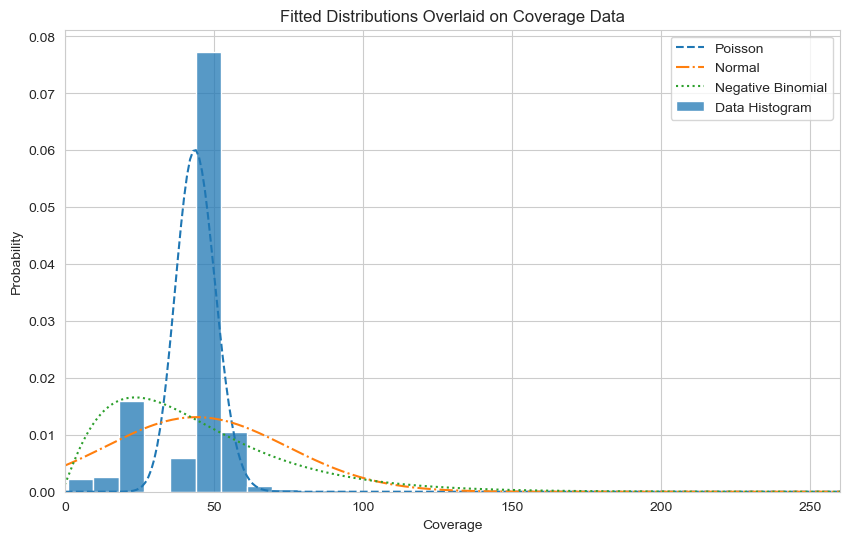

Mean Coverage:
 44.10155378033706
Std Ev:
 30.43957037381469
Max Observed Coverage:
 1731


In [85]:


# For the Poisson distribution, we use the mean as the lambda parameter
poisson_rv = stats.poisson(coverage_mean)

# For the Normal distribution, we use the calculated mean and standard deviation
normal_rv = stats.norm(coverage_mean, np.sqrt(coverage_var))

# For the Negative Binomial distribution, we need to estimate the parameters.
k = coverage_mean**2 / (coverage_var - coverage_mean) if coverage_var > coverage_mean else 10
neg_binom_rv = stats.nbinom(k, k / (k + coverage_mean))

# Create a range of x values that span the observed data for plotting
x = np.arange(0, coverage_max + 1)

# Calculate the probability mass/density function for each distribution at each x value
poisson_pmf = poisson_rv.pmf(x)
normal_pdf = normal_rv.pdf(x)
neg_binom_pmf = neg_binom_rv.pmf(x)

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(nonzero_cov.loc[nonzero_cov['coverage'] < MAX_cov, 'coverage'], kde=False, bins=30, stat='density', label='Data Histogram')
plt.plot(x, poisson_pmf, label='Poisson', linestyle='--')
plt.plot(x, normal_pdf, label='Normal', linestyle='-.')
plt.plot(x, neg_binom_pmf, label='Negative Binomial', linestyle=':')
plt.title('Fitted Distributions Overlaid on Coverage Data')
plt.xlabel('Coverage')
plt.ylabel('Probability')
plt.xlim(0,MAX_cov)
plt.legend()
plt.show()

print("Mean Coverage:\n",coverage_mean)
#stdev
print("Std Ev:\n",np.sqrt(coverage_var))
print("Max Observed Coverage:\n",coverage_max)

Stdev is VERY HIGH!!!!
This shows how variable and overdispersed the data is



In [75]:
def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two PMFs.
    Both p and q are numpy arrays of the same length, where p represents the
    'true' distribution and q represents the approximate distribution.
    p is the empirical or 'true' distribution, and q is the estimated distribution.
    """
    # Avoid division by zero and taking the log of zero by adding a small amount to both distributions
    p = np.maximum(p, 1e-10)
    q = np.maximum(q, 1e-10)
    return np.sum(p * np.log(p / q))


empirical_counts , _ = np.histogram(nonzero_cov['coverage'], bins=30)

# Assume empirical_counts is an array representing the histogram counts of the empirical distribution
# Normalize the empirical histogram to create an empirical PMF
empirical_pmf = empirical_counts / empirical_counts.sum()


# Assuming poisson_pmf and neg_binom_pmf are the PMFs of the Poisson and Negative Binomial distributions
# Normalize these PMFs to ensure they sum to 1 over the range of the empirical data
poisson_pmf_normalized = poisson_pmf / poisson_pmf.sum()
neg_binom_pmf_normalized = neg_binom_pmf / neg_binom_pmf.sum()

# Compute the KL divergence between the Poisson/Negative Binomial PMFs and the empirical PMF
kl_div_poisson_emp = kl_divergence(poisson_pmf_normalized[:len(empirical_pmf)], empirical_pmf)
kl_div_neg_binom_emp = kl_divergence(neg_binom_pmf_normalized[:len(empirical_pmf)], empirical_pmf)

kl_div_poisson_emp, kl_div_neg_binom_emp


(0.03955772594487928, 2.4896752799564106)

KL divergence shows

Copy number annotations are obtained from a tool hmcnc -  hidden markov model based cn caller

In [78]:
# Prepare the data for regression
nonzero_cov['scaled_coverage'] = nonzero_cov['coverage'] / haploid_mean_coverage
X = nonzero_cov[['scaled_coverage']]
y_d = data[data['coverage'] >0]
y = y_d['copynumber']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
mse


/var/folders/k5/p3smml613rz1hw258xhg_5zm0000gn/T/ipykernel_65191/617091353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonzero_cov['scaled_coverage'] = nonzero_cov['coverage'] / haploid_mean_coverage


0.5771665527494072

In [82]:
# In statsmodels, we add a constant to the predictors for an intercept term
X_train_with_intercept = sm.add_constant(X_train)

# Fit a Negative Binomial regression model
neg_binom_model = sm.GLM(y_train, X_train_with_intercept, family=sm.families.NegativeBinomial())
neg_binom_results = neg_binom_model.fit()

# Display the summary of the regression results
neg_binom_results.summary()


/Users/red/miniconda3/envs/sb/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             copynumber   No. Observations:               373437
Model:                            GLM   Df Residuals:                   373435
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.9190e+05
Date:                Fri, 03 Nov 2023   Deviance:                       23708.
Time:                        15:20:05   Pearson chi2:                 9.22e+03
No. Iterations:                   100   Pseudo R-squ. (CS):            0.05042
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1138      0.003    -35.159      0.000      -0.120      -0.107
scaled_coverage     0.5285      0.001    419.869      0.000       0.526       0.531
===================================================================================
"""

The low pseudo R-squared value indicates that while the predictors are significant, they do not explain a large portion of the variability in copy numbers. This might suggest that other factors not included in the model also affect the copy number.
The relatively large number of iterations to converge may suggest that the estimation process was challenging, possibly due to the nature of the data or the initial parameter estimates.
In summary, while the model finds a significant relationship between scaled coverage and copy number, the predictive power of the model is quite low. Additional variables or more complex models might be necessary to better capture the variability in the copy number data